In [41]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from interpolation import BarycentricInterpolation
from collocation_improved import lagrange_basis
from scipy.integrate import quad

### Simple Linear ODE

In [42]:
def f(t, u):
    return -u 

### Params and collocation points

In [43]:
T = 1.0  # end time
N = 10  # number of grid points
interpolator = BarycentricInterpolation(N, start=0, stop=T)
t_grid = interpolator.nodes

### Lagrange and Interpolation

In [44]:
def lagrange_basis(t, k, t_grid):
    terms = [(t - t_grid[m]) / (t_grid[k] - t_grid[m]) for m in range(len(t_grid)) if m != k]
    return jnp.prod(jnp.array(terms))


def interpolate(u, t, t_grid):
    """
    u: The array of function values at the grid points
    t: The point at which to interpolate
    t_grid: The array of interpolation nodes
    """
    if u.ndim == 1:
        return jnp.sum(jnp.array([u_k * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)]))
    return jnp.array([jnp.sum(jnp.array([u_k[i] * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)])) for i in range(u.shape[1])])


### Integral Function 
* to compute the integral of $f$ from $t_k$ to $t_{k+1}$ using the trapezoid rule

In [45]:
def integral(f, t_k, t_k1, u, t_grid):
    """
    s - variable of integration
    t_k - lower bound of the integral
    t_k1 - upper bound of the integral
    u - array of function values at the grid points
    t_grid - the array of interpolation nodes
    """
    integrand = lambda s: f(s, interpolate(u, s, t_grid))
    vectorized_integrand = jax.vmap(integrand)
    s_values = jnp.linspace(t_k, t_k1, 100)
    integrand_values = vectorized_integrand(s_values)
    integral_value = jnp.trapezoid(integrand_values, s_values, axis=0)
    return integral_value


### Collocation System

In [46]:
def system(u, t_grid, f, u0):
    eqs = [u[0] - u0]
    
    for k in range(1, len(t_grid)):
        eq = u[k] - u[k-1] - integral(f, t_grid[k-1], t_grid[k], u, t_grid)
        eqs.append(eq)
    
    return jnp.array(eqs)

The Newton-Raphson method for solving a system of nonlinear equations involves iteratively solving the linear system:

$$
\mathbf{J}(u) \Delta u = -\mathbf{F}(u)
$$

for the correction term $\Delta u$, where $\mathbf{J}(u)$ is the Jacobian matrix of the system of equations $\mathbf{F}(u)$ at the current approximation $u$.


$\mathbf{J}(u) \Delta u = -\mathbf{F}(u)$

In [47]:
def newton_method(u_init, t_grid, f, u0 = 1, tol=1e-3, max_iter=100):
    u = u_init
    for i in range(max_iter):
        F_u = system(u, t_grid, f, u0)
        
        # Jacobian 
        J_u = jacfwd(system)(u, t_grid, f, u0)
        
        # flatten the Jacobian and F_u for solving
        F_u_flat = F_u.reshape(-1)
        J_u_flat = J_u.reshape(F_u_flat.shape[0], -1)
        
        # solve for the update Δu in the linear system J(u) Δu = -F(u)
        delta_u_flat = jnp.linalg.solve(J_u_flat, -F_u_flat)
        
        # reshape the update and apply
        delta_u = delta_u_flat.reshape(u.shape)
        u = u + delta_u
        
        norm_delta_u = jnp.linalg.norm(delta_u)
        if norm_delta_u < tol:
            print(f"Converged at iteration {i+1}")
            return u
    
    raise ValueError("Newton's method did not converge")

In [48]:
# initial guess
u_init = jnp.ones((N,)) 

u_solution = newton_method(u_init, t_grid, f)

print("Solution at grid points:", u_solution)

Converged at iteration 2
Solution at grid points: [1.         0.9702964  0.88960496 0.77880076 0.66154586 0.55609052
 0.47236648 0.41353117 0.37914124 0.36787938]


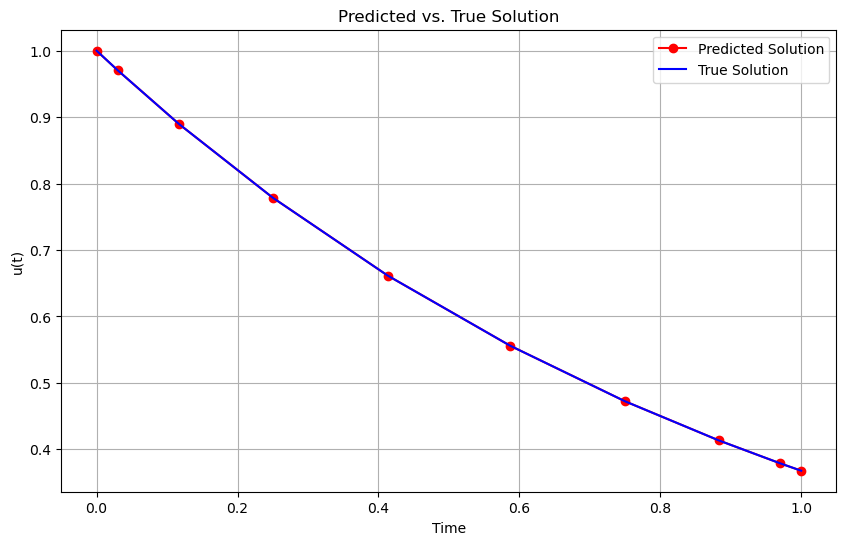

In [49]:
u0 = 1.0  # initial condition
true_solution = u0 * jnp.exp(-t_grid)

plt.figure(figsize=(10, 6))
plt.plot(t_grid, u_solution, 'ro-', label='Predicted Solution')
plt.plot(t_grid, true_solution, 'b-', label='True Solution')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted vs. True Solution')
plt.grid(True)
plt.show()

In [50]:
omega = 2.0 

def f_2(t, uv):
    # print(type(uv))
    u, v = uv
    return jnp.array([v, -omega**2 * u])

T = 4.0  # End time
N = 20  # Number of grid points

interpolator = BarycentricInterpolation(N, start=0, stop=T)
t_grid = interpolator.nodes

# initial guess
uv_init = jnp.ones((N, 2)) 

# initial velocity to 0
uv_init = uv_init.at[0, 1].set(0)  

u0=jnp.array([1.0, 0.0])

uv_solution = newton_method(uv_init, t_grid, f_2, u0)

print("Solution at grid points:", uv_solution)

Converged at iteration 2
Solution at grid points: [[ 1.          0.        ]
 [ 0.99851226 -0.10905546]
 [ 0.97660563 -0.4300765 ]
 [ 0.886021   -0.92729019]
 [ 0.66489927 -1.49386604]
 [ 0.27628258 -1.92215285]
 [-0.23907049 -1.94200436]
 [-0.73279309 -1.36090292]
 [-0.99237846 -0.24645377]
 [-0.86377539  1.00775383]
 [-0.37285378  1.85578008]
 [ 0.26628758  1.92778713]
 [ 0.77981931  1.25200919]
 [ 0.9954519   0.19053038]
 [ 0.91065793 -0.82632219]
 [ 0.64225663 -1.53297932]
 [ 0.32981368 -1.88809209]
 [ 0.07067343 -1.99499901]
 [-0.09131642 -1.99164385]
 [-0.14548048 -1.97872225]]


In [11]:
t = jnp.linspace(0, T, 100)

interpolator.fit(jnp.transpose(uv_solution)[0])
x0 = interpolator.evaluate(t)

interpolator.fit(jnp.transpose(uv_solution)[1])
x1 = interpolator.evaluate(t)

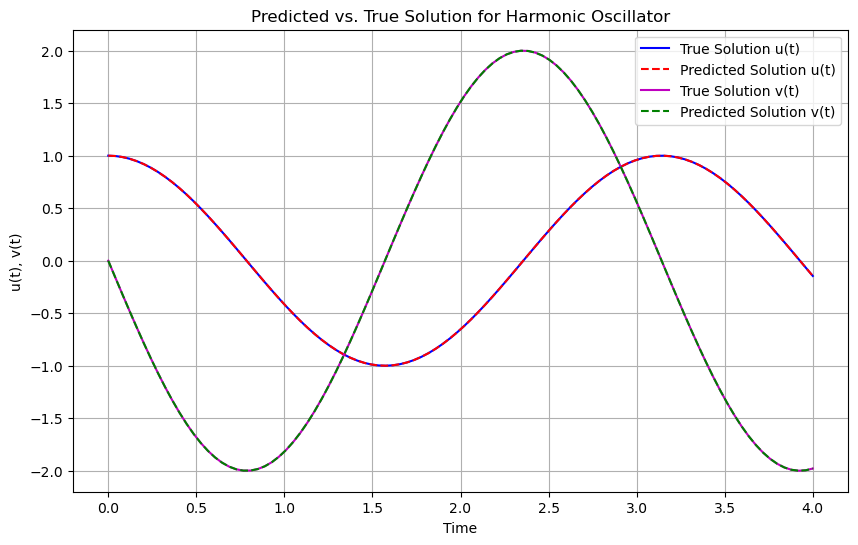

In [12]:
true_solution_u = jnp.cos(omega * t)
true_solution_v = -omega * jnp.sin(omega * t)

plt.figure(figsize=(10, 6))
plt.plot(t, true_solution_u, 'b-', label='True Solution u(t)')
plt.plot(t, x0, 'r--', label='Predicted Solution u(t)')
plt.plot(t, true_solution_v, 'm-', label='True Solution v(t)')
plt.plot(t, x1, 'g--', label='Predicted Solution v(t)')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted vs. True Solution for Harmonic Oscillator')
plt.grid(True)
plt.show()

In [20]:
import jax
import jax.numpy as jnp
from jax import jacfwd, jit

# Define the function f(t, u)
def f(t, u):
    # Example: u'(t) = -u(t), simple ODE
    return -u

# Define the grid and the collocation points
T = 1.0
N = 10
t_grid = jnp.linspace(0, T, N)

# Define the Lagrange basis and its derivative
def lagrange_basis(t, k, t_grid):
    terms = [(t - t_grid[m]) / (t_grid[k] - t_grid[m]) for m in range(len(t_grid)) if m != k]
    return jnp.prod(jnp.array(terms))

def lagrange_basis_derivative(t, k, t_grid):
    def basis_derivative(s):
        terms = []
        for m in range(len(t_grid)):
            if m != k:
                prod = 1.0 / (t_grid[k] - t_grid[m])
                for j in range(len(t_grid)):
                    if j != k and j != m:
                        prod *= (s - t_grid[j]) / (t_grid[k] - t_grid[j])
                terms.append(prod)
        return sum(terms)
    return basis_derivative(t)

# Define the derivative matrix L'
L_prime = jnp.zeros((N, N))
for i in range(N):
    for j in range(N):
        L_prime = L_prime.at[i, j].set(lagrange_basis_derivative(t_grid[i], j, t_grid))

# Define the function F(u)
def F(u):
    def F_i(i):
        sum_term = 0.0
        for k in range(N):
            sum_term += u[k] * lagrange_basis(t_grid[i], k, t_grid)
        return f(t_grid[i], sum_term)
    
    F_vec = jax.vmap(F_i)(jnp.arange(N))
    return F_vec

# Define the function G(u)
def G(u):
    return jnp.dot(L_prime, u) - F(u)

# Define the Jacobian of G(u)
J_G = jacfwd(G)

# Newton's method to solve G(u) = 0
def newtons_method(u_init, tol=1e-6, max_iter=100):
    u = u_init
    for i in range(max_iter):
        G_val = G(u)
        J_G_val = J_G(u)
        delta_u = jax.scipy.linalg.solve(J_G_val, -G_val)
        u = u + delta_u
        if jnp.linalg.norm(delta_u) < tol:
            print(f"Converged at iteration {i+1}")
            return u
    raise ValueError("Newton's method did not converge")

# Initial guess for u
u_init = jnp.zeros(N)
u_init = u_init.at[0].set(1.0)  # initial condition u(0) = u0

# Solve the system
u_sol = newtons_method(u_init)

# Print the solution
print("Solution u at collocation points:", u_sol)


Converged at iteration 2
Solution u at collocation points: [-8.12584406e-11 -7.27132475e-11 -6.50666727e-11 -5.82242169e-11
 -5.21013185e-11 -4.66223083e-11 -4.17194745e-11 -3.73322260e-11
 -3.34063436e-11 -2.98933097e-11]
